# <center> Vanishing/Exploding Gradients Problems <center>
---

Gradients often get smaller and smaller as the algorithm progresses
down to the lower layers. As a result, the Gradient Descent update leaves the lower
layer connection weights virtually unchanged, and training never converges to a good
solution. This is called the vanishing gradients problem. In some cases, the opposite
can happen: the gradients can grow bigger and bigger, so many layers get insanely
large weight updates and the algorithm diverges. This is the exploding gradients problem, which is mostly encountered in recurrent neural networks.
More generally, deep neural networks suffer from unstable gradients; different layers
may learn at widely different speeds.

A paper titled “Understanding the Difficulty of Training Deep Feedforward
Neural Networks” by Xavier Glorot and Yoshua Bengio found a few suspects, **including the combination of the popular logistic sigmoid activation function and the
weight initialization technique that was most popular at the time, namely random initialization using a normal distribution with a mean of 0 and a standard deviation of 1.
In short, they showed that with this activation function and this initialization scheme,
the variance of the outputs of each layer is much greater than the variance of its
inputs. Going forward in the network, the variance keeps increasing after each layer
until the activation function saturates at the top layers. This is actually made worse by
the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent
function has a mean of 0 and behaves slightly better than the logistic function in deep
networks).**

---

## Xavier and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate this prob
lem. We need the signal to flow properly in both directions: in the forward direction
when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate.
For the signal to flow properly, the authors argue that we need **the variance of the
outputs of each layer to be equal to the variance of its inputs**, and we also need the
**gradients to have equal variance before and after flowing through a layer in the
reverse direction. It is actually not possible to guarantee both unless the layer has an equal
number of input and output connections**, but they proposed a good compromise that
has proven to work very well in practice, **the connection weights must be initialized
randomly as described in the following equation:**

- Normal distribution with mean 0 and standard deviation $σ = \sqrt{2 \over n_{inputs} + n_{outputs}}$

- Or a uniform distribution between ‐r and +r, with $r = \sqrt{6 \over n_{inputs} + n_{outputs}}$

where $ n_{inputs}$ and $n_{outputs}$ are the number of input and output connections for the layer whose weights are being initialized (also called fan-in and fan-out). This initialization strategy is often called **Xavier initialization (after the author’s first name), or sometimes Glorot initialization.**

Using the Xavier initialization strategy can speed up training considerably, and it is
one of the tricks that led to the current success of Deep Learning. Some recent papers
have provided similar strategies for different activation functions, as shown in
Table 11-1. The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called He initialization (after the last name of its author):

In [1]:
from IPython.display import Image 

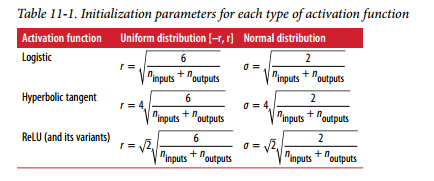

In [2]:
Image("/home/antonio/Dropbox/DataAnalysis/ToDoList/Primary/Deep_Learning/Tensorflow/Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow/Notebooks/Screenshot from 2017-06-20 21-53-11.png")

By default, the tf.layers.dense() function (introduced in Chapter 10) uses Xavier
initialization (with a uniform distribution). You can change this to He initialization
by using the variance_scaling_initializer() function like this:

In [3]:
import tensorflow as tf
he_init = tf.contrib.layers.variance_scaling_initializer()
X = tf.placeholder(dtype=tf.float32,shape=(None,1000))
n_hidden1 = 100
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
kernel_initializer=he_init, name="hidden1")

**He initialization considers only the fan-in, not the average between
fan-in and fan-out like in Xavier initialization. This is also the
default for the variance_scaling_initializer() function, but
you can change this by setting the argument mode="FAN_AVG".**

## Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the vanishing/
exploding gradients problems were in part due to a poor choice of activation function.
Until then most people had assumed that if Mother Nature had chosen to use
roughly sigmoid activation functions in biological neurons, they must be an excellent
choice. But it turns out that other activation functions behave much better in deep
neural networks, in particular **the ReLU activation function, mostly because it does
not saturate for positive values (and also because it is quite fast to compute).**
Unfortunately, the ReLU activation function is not perfect. It suffers from a problem
known as the **dying ReLUs: during training, some neurons effectively die, meaning
they stop outputting anything other than 0.** In some cases, you may find that half of
your network’s neurons are dead, especially if you used a large learning rate. **During
training, if a neuron’s weights get updated such that the weighted sum of the neuron’s
inputs is negative, it will start outputting 0. When this happen, the neuron is unlikely
to come back to life since the gradient of the ReLU function is 0 when its input is
negative.**

To solve this problem, you may want to use a variant of the ReLU function, such as
the **leaky ReLU**. This function is defined as $LeakyReLU_α(z) = max(αz, z)$. 
The hyperparameter α defines how much the function “leaks”: it is the
slope of the function for z < 0, and is typically set to 0.01. This small slope ensures
that leaky ReLUs never die; they can go into a long coma, but they have a chance to
eventually wake up. A recent paper compared several variants of the ReLU activation
function and one of its conclusions was that the leaky variants always outperformed
the strict ReLU activation function. In fact, **setting α = 0.2 (huge leak) seemed to
result in better performance than α = 0.01 (small leak). They also evaluated the
randomized leaky ReLU (RReLU), where α is picked randomly in a given range during
training, and it is fixed to an average value during testing. It also performed fairly well
and seemed to act as a regularizer (reducing the risk of overfitting the training set).**
Finally, they also evaluated the **parametric leaky ReLU (PReLU)**, where α is authorized
to be learned during training (instead of being a hyperparameter, it becomes a
parameter that can be modified by backpropagation like any other parameter). **This was reported to strongly outperform ReLU on large image datasets, but on smaller
datasets it runs the risk of overfitting the training set.**

Last but not least, a 2015 paper by Djork-Arné Clevert et al. proposed a new activation function called the **exponential linear unit (ELU)** that outperformed all the ReLU
variants in their experiments: training time was reduced and the neural network per‐
formed better on the test set. ELU activation function:

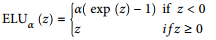

In [4]:
Image("/home/antonio/Dropbox/DataAnalysis/ToDoList/Primary/Deep_Learning/Tensorflow/Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow/Notebooks/ELU.png")

It looks a lot like the ReLU function, with a few major differences:
- First it takes on negative values when z < 0, which allows the unit to have an average output closer to 0. This helps alleviate the vanishing gradients problem, as discussed earlier. The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter if you want.
- Second, it has a nonzero gradient for z < 0, which avoids the dying units issue.
- Third, the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent, since it does not bounce as much left and right of z = 0.

The main drawback of the ELU activation function is that it is slower to compute
than the ReLU and its variants (due to the use of the exponential function), but during training this is compensated by the faster convergence rate. However, at test time
an ELU network will be slower than a ReLU network.

So which activation function should you use for the hidden layers
of your deep neural networks? Although your mileage will vary, **in
general ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic.** If you care a lot about runtime performance, then you may prefer leaky ReLUs over ELUs. If you don’t want to tweak yet another
hyperparameter, you may just use the default α values suggested
earlier (0.01 for the leaky ReLU, and 1 for ELU). If you have spare
time and computing power, you can use cross-validation to evaluate other activation functions, in particular RReLU if your network
is overfitting, or PReLU if you have a huge training set.

TensorFlow offers an elu() function that you can use to build your neural network.
Simply set the activation argument when calling the dense() function, like this:

In [5]:
hidden = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden")

TensorFlow does not have a predefined function for leaky ReLUs, but it is easy
enough to define:

In [6]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)
hidden2 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden2")

## Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.
In a 2015 paper Sergey Ioffe and Christian Szegedy proposed a technique called
Batch Normalization (BN) to address the vanishing/exploding gradients problems,
and more generally the problem that the distribution of each layer’s inputs changes
during training, as the parameters of the previous layers change (which they call the
Internal Covariate Shift problem).
The technique consists of adding an operation in the model just before the activation
function of each layer, simply zero-centering and normalizing the inputs, then scaling
and shifting the result using two new parameters per layer (one for scaling, the other
for shifting). In other words, this operation lets the model learn the optimal scale and
mean of the inputs for each layer.
In order to zero-center and normalize the inputs, the algorithm needs to estimate the
inputs’ mean and standard deviation. It does so by evaluating the mean and standard
deviation of the inputs over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized in Equation 11-3.

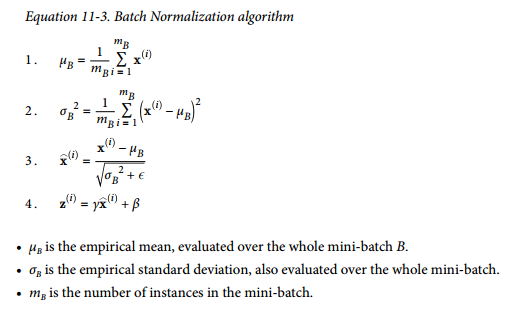

In [9]:
Image("/home/antonio/Dropbox/DataAnalysis/ToDoList/Primary/Deep_Learning/Tensorflow/Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow/Notebooks/BatchNormalizationAlgorithm.png")

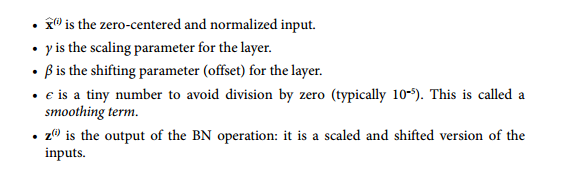

In [10]:
Image("/home/antonio/Dropbox/DataAnalysis/ToDoList/Primary/Deep_Learning/Tensorflow/Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow/Notebooks/BatchNormalizationAlgorithm2.png")

At test time, there is no mini-batch to compute the empirical mean and standard
deviation, so instead you simply use the whole training set’s mean and standard deviation. These are typically efficiently computed during training using a moving average. So, in total, four parameters are learned for each batch-normalized layer: 
- γ(scale)
- β (offset)
- μ (mean)
- σ (standard deviation)

The authors demonstrated that this technique considerably improved all the deep
neural networks they experimented with. The vanishing gradients problem was
strongly reduced, to the point that they could use saturating activation functions such
as the tanh and even the logistic activation function. The networks were also much
less sensitive to the weight initialization. They were able to use much larger learning
rates, significantly speeding up the learning process. Specifically, they note that
“Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original
model by a significant margin. Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of
human raters.” Finally, like a gift that keeps on giving, Batch Normalization also acts
like a regularizer, reducing the need for other regularization techniques (such as
dropout, described later).
Batch Normalization does, however, add some complexity to the model (although it
removes the need for normalizing the input data since the first hidden layer will take
care of that, provided it is batch-normalized). Moreover, there is a runtime penalty:
the neural network makes slower predictions due to the extra computations required
at each layer. So if you need predictions to be lightning-fast, you may want to check
how well plain ELU + He initialization perform before playing with Batch Normalization.

TensorFlow provides a tf.nn.batch_normalization() function that simply centers
and normalizes the inputs, but you must compute the mean and standard deviation
yourself (based on the mini-batch data during training or on the full dataset during
testing, as just discussed) and pass them as parameters to this function, and you must
also handle the creation of the scaling and offset parameters (and pass them to this
function). It is doable, but not the most convenient approach. Instead, you should use
the tf.layers.batch_normalization() function, which handles all this for you, as
in the following code:

In [11]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')
hidden_1 = tf.layers.dense(X, n_hidden1, name="hidden_1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)
hidden_2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden_2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
momentum=0.9)

Let’s walk through this code. The first lines are fairly self-explanatory, until we define
the training placeholder: **we will set it to True during training, but otherwise it will
default to False.** This will be used to tell the tf.layers.batch_normalization()
function whether it should use the current mini-batch’s mean and standard deviation
(during training) or the whole training set’s mean and standard deviation (during
testing).

Then, we alternate fully connected layers and batch normalization layers: the fully
connected layers are created using the tf.layers.dense() function. Note that we don’t specify any activation function for the fully connected layers because we want to apply the activation function after each batch normalization layer. We create the batch normalization layers using the tf.layers.batch_normalization() function, setting its training and momentum
parameters. The BN algorithm uses exponential decay to compute the running averages, which is why it requires the momentum parameter: given a new value v, the running average v is updated through the equation:

v^ <- v^ × momentum + v × (1 − momentum)

A good momentum value is typically close to 1—for example, 0.9, 0.99, or 0.999 (you
want more 9s for larger datasets and smaller mini-batches).

You may have noticed that the code is quite repetitive, with the same batch normalization parameters appearing over and over again. To avoid this repetition, you can
use the partial() function from the functools module (part of Python’s standard
library). It creates a thin wrapper around a function and allows you to define default
values for some parameters. The creation of the network layers in the preceding code
can be modified like so:

In [ ]:
from functools import partial
my_batch_norm_layer = partial(tf.layers.batch_normalization,
training=training, momentum=0.9)
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

It may not look much better than before in this small example, but if you have 10 layers and want to use the same activation function, initializer, regularizer, and so on, in
all layers, this trick will make your code much more readable.
The rest of the construction phase is the same as always, define the cost function, create an optimizer, tell it to minimize the cost function, define the evaluation
operations, create a Saver, and so on.
The execution phase is also pretty much the same, with two exceptions. First, during
training, whenever you run an operation that depends on the batch_normalization() layer, you need to set the training placeholder to True. Second, the
batch_normalization() function creates a few operations that must be evaluated at
each step during training in order to update the moving averages (recall that these
moving averages are needed to evaluate the training set’s mean and standard devia‐
tion). These operations are automatically added to the UPDATE_OPS collection, so all we need to do is get the list of operations in that collection and run them at each
training iteration:

In [ ]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                    feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
        y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

## Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the
gradients during backpropagation so that they never exceed some threshold, this is called Gradient
Clipping. In general people now prefer Batch Normalization, but it’s still useful to
know about Gradient Clipping and how to implement it.
In TensorFlow, the optimizer’s minimize() function takes care of both computing the
gradients and applying them, so you must instead call the optimizer’s compute_gradients() method first, then create an operation to clip the gradients using the clip_by_value() function, and finally create an operation to apply the clipped gradients using the optimizer’s apply_gradients() method:

In [ ]:
threshold = 1.0
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
                for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

You would then run this training_op at every training step, as usual. It will compute
the gradients, clip them between –1.0 and 1.0, and apply them. **The threshold is a
hyperparameter you can tune.**